# LOADING THE DATA

In [1217]:
import numpy as np
import pandas as pd
from google.colab import drive

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score
import datetime
from sklearn.cluster import KMeans
from math import sin, cos, sqrt, atan2, radians
import geopy.distance
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV

RANDOM_SEED = 6    

drive.mount('/content/drive/')
sns.set()



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
train = pd.read_csv('/content/drive/My Drive/Data Sets/ML data/details/train.csv',index_col="tripid")
test  = pd.read_csv('/content/drive/My Drive/Data Sets/ML data/details/test.csv',index_col="tripid")
sub =  pd.read_csv('/content/drive/My Drive/Data Sets/ML data/details/sample_submission.csv',index_col="tripid")

In [1219]:
train

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,correct
213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,correct
213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,correct


In [1220]:
test

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
tripid,,,,,,,,,,,,
213284604,10.5,924,42,2.44860,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
213286352,10.5,4249,20,0.00000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
213293973,10.5,1552,255,2.65880,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
213294622,10.5,462,16,0.00000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
213298687,10.5,814,392,12.36920,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47
...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,10.5,1723,429,24.83332,3,3/16/2020 21:28,3/16/2020 21:56,6.85103,79.9567,6.85588,79.9214,388.48
222857785,10.5,1378,80,0.00000,125,3/16/2020 21:59,3/16/2020 22:22,6.91293,79.9656,6.92112,79.8980,379.85
222858416,10.5,418,56,3.28440,93,3/16/2020 22:02,3/16/2020 22:09,6.85718,79.9081,6.83868,79.9083,112.79


In [1221]:
print(sub.info())
print(train.info())
print(train['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8576 entries, 213284604 to 222860703
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   prediction  8576 non-null   int64
dtypes: int64(1)
memory usage: 134.0 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17176 entries, 189123628 to 213817296
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            16974 non-null  float64
 1   duration                   16974 non-null  float64
 2   meter_waiting              16974 non-null  float64
 3   meter_waiting_fare         16974 non-null  float64
 4   meter_waiting_till_pickup  16974 non-null  float64
 5   pickup_time                17176 non-null  object 
 6   drop_time                  17176 non-null  object 
 7   pick_lat                   17176 non-null  float64
 8   pick_lon                   17176 

In [1222]:
cleanup_label = {"label":     {'correct': '1' , 'incorrect': '0'}}
train.replace(cleanup_label, inplace=True)
convert_dict = {'label': 'int64'}
train = train.astype(convert_dict) 
print(train['label'].value_counts())

train

1    15495
0     1681
Name: label, dtype: int64


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,1
213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,1
213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,1


## create entire dataset

In [1223]:
frames = [train, test]
dataset = pd.concat(frames)
dataset

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.00000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1.0
189125358,10.5,791.0,47.0,0.00000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1.0
189125719,10.5,1087.0,80.0,0.00000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1.0
189127273,10.5,598.0,271.0,15.66380,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1.0
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,10.5,1723.0,429.0,24.83332,3.0,3/16/2020 21:28,3/16/2020 21:56,6.85103,79.9567,6.85588,79.9214,388.48,NaN
222857785,10.5,1378.0,80.0,0.00000,125.0,3/16/2020 21:59,3/16/2020 22:22,6.91293,79.9656,6.92112,79.8980,379.85,NaN
222858416,10.5,418.0,56.0,3.28440,93.0,3/16/2020 22:02,3/16/2020 22:09,6.85718,79.9081,6.83868,79.9083,112.79,NaN


In [1224]:
dataset = dataset.drop_duplicates(keep='first')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25748 entries, 189123628 to 222860703
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            25547 non-null  float64
 1   duration                   25547 non-null  float64
 2   meter_waiting              25547 non-null  float64
 3   meter_waiting_fare         25547 non-null  float64
 4   meter_waiting_till_pickup  25547 non-null  float64
 5   pickup_time                25748 non-null  object 
 6   drop_time                  25748 non-null  object 
 7   pick_lat                   25748 non-null  float64
 8   pick_lon                   25748 non-null  float64
 9   drop_lat                   25748 non-null  float64
 10  drop_lon                   25748 non-null  float64
 11  fare                       25611 non-null  float64
 12  label                      17172 non-null  float64
dtypes: float64(11), object(2)
memory u

In [0]:
## handle NaN values
#dataset = dataset.fillna(0)
#dataset

## Calculate Distance

In [1226]:
train_distance_dict = {}

for ind in dataset.index:
  pickup_lat = dataset['pick_lat'][ind]
  pickup_long = dataset['pick_lon'][ind]
  drop_lat = dataset['drop_lat'][ind]
  drop_long = dataset['drop_lon'][ind]
  coords_1 = (pickup_lat, pickup_long)
  coords_2 = (drop_lat, drop_long)
  distance = geopy.distance.vincenty(coords_1, coords_2).km
  train_distance_dict[ind] = distance

dataset['distance_val'] = dataset.index.to_series().map(train_distance_dict)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


## Date and Time

In [1227]:
pickup_date_time = dataset[["pickup_time"]]
print("pickup_date_time.shape", pickup_date_time.shape)


pickup_date_time.shape (25748, 1)


In [1228]:
drop_date_time = dataset[["drop_time"]]
print("drop_date_time.shape", drop_date_time.shape)


drop_date_time.shape (25748, 1)


In [1229]:
dataset['pickup_time'] = dataset['pickup_time'].astype('datetime64[ns]')
dataset['drop_time'] = dataset['drop_time'].astype('datetime64[ns]')


dataset['year'] = dataset.pickup_time.dt.year

dataset['month'] = dataset.pickup_time.dt.month

dataset['day'] =dataset.pickup_time.dt.day

dataset['pickup_hour'] = dataset.pickup_time.dt.hour

dataset['pickup_min'] = dataset.pickup_time.dt.minute

dataset['drop_hour'] = dataset.drop_time.dt.hour

dataset['drop_min'] = dataset.drop_time.dt.minute

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [0]:
# Monday is 0 and Sunday is 6.
date_name_dict = {}
for ind in dataset.index:
  year =  dataset['year'][ind].astype(np.int64)
  month =  dataset['month'][ind].astype(np.int64)
  day =  dataset['day'][ind].astype(np.int64)
  date_obj = datetime.date(year,month,day)
  date_Day  = date_obj.weekday()
  date_name_dict[ind] = date_Day

In [1231]:
dataset['weekday'] = dataset.index.to_series().map(date_name_dict)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1232]:
dataset['weekday'].value_counts()

4    3959
3    3862
5    3792
2    3742
1    3680
0    3675
6    3038
Name: weekday, dtype: int64

## location clustering using KMean(elbow curve)

### pickup clustering

In [1233]:
pickup_location = dataset[['pick_lat','pick_lon']]   #pick_lat	pick_lon
drop_location = dataset[['drop_lat','drop_lon']]  #drop_lat	drop_lon
pickup_location

,pick_lat,pick_lon
tripid,,
189123628,6.86252,79.8993
189125358,6.88589,79.8984
189125719,6.90839,79.8651
189127273,6.92570,79.8895
189128020,6.87441,79.8615
...,...,...
222856243,6.85103,79.9567
222857785,6.91293,79.9656
222858416,6.85718,79.9081


In [1234]:
dataset.columns[7:9]

Index(['pick_lat', 'pick_lon'], dtype='object')

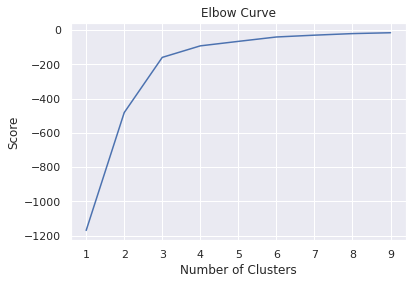

In [1235]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = dataset[['pick_lat']]
X_axis = dataset[['pick_lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()
#When we graph the plot, we see that the graph levels off slowly after 3 clusters. This implies that addition of more clusters will not help us that much.

In [1236]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(pickup_location[pickup_location.columns[0:2]]) # Compute k-means clustering.
dataset['pick_location_cluster'] = kmeans.fit_predict(pickup_location[pickup_location.columns[0:2]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(pickup_location[pickup_location.columns[0:2]]) # Labels of each point
print(dataset['pick_location_cluster'].value_counts())
dataset

0    21742
1     3554
2      452
Name: pick_location_cluster, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance_val,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster
tripid,,,,,,,,,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.00000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1.0,5.072065,2019,11,1,0,20,0,34,4,0
189125358,10.5,791.0,47.0,0.00000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1.0,3.151780,2019,11,1,0,56,1,9,4,0
189125719,10.5,1087.0,80.0,0.00000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1.0,6.302418,2019,11,1,1,8,1,26,4,0
189127273,10.5,598.0,271.0,15.66380,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1.0,0.862654,2019,11,1,2,27,2,37,4,0
189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1.0,8.148521,2019,11,1,3,34,3,51,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,10.5,1723.0,429.0,24.83332,3.0,2020-03-16 21:28:00,2020-03-16 21:56:00,6.85103,79.9567,6.85588,79.9214,388.48,NaN,3.938380,2020,3,16,21,28,21,56,0,0
222857785,10.5,1378.0,80.0,0.00000,125.0,2020-03-16 21:59:00,2020-03-16 22:22:00,6.91293,79.9656,6.92112,79.8980,379.85,NaN,7.525493,2020,3,16,21,59,22,22,0,0
222858416,10.5,418.0,56.0,3.28440,93.0,2020-03-16 22:02:00,2020-03-16 22:09:00,6.85718,79.9081,6.83868,79.9083,112.79,NaN,2.046036,2020,3,16,22,2,22,9,0,0


### drop clustering

In [1237]:
dataset.columns[9:11]

Index(['drop_lat', 'drop_lon'], dtype='object')

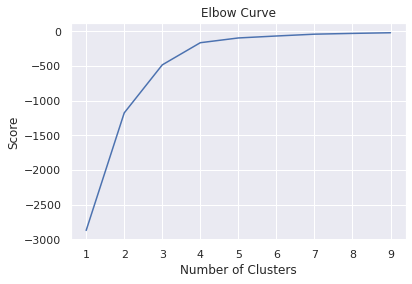

In [1238]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = dataset[['drop_lat']]
X_axis = dataset[['drop_lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()
#When we graph the plot, we see that the graph levels off slowly after 3 clusters. This implies that addition of more clusters will not help us that much.

In [1239]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(drop_location[drop_location.columns[0:2]]) # Compute k-means clustering.
dataset['drop_location_cluster'] = kmeans.fit_predict(drop_location[drop_location.columns[0:2]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(drop_location[drop_location.columns[0:2]]) # Labels of each point
print(dataset['drop_location_cluster'].value_counts())
dataset

0    22191
2     3556
1        1
Name: drop_location_cluster, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance_val,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster,drop_location_cluster
tripid,,,,,,,,,,,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.00000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1.0,5.072065,2019,11,1,0,20,0,34,4,0,0
189125358,10.5,791.0,47.0,0.00000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1.0,3.151780,2019,11,1,0,56,1,9,4,0,0
189125719,10.5,1087.0,80.0,0.00000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1.0,6.302418,2019,11,1,1,8,1,26,4,0,0
189127273,10.5,598.0,271.0,15.66380,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1.0,0.862654,2019,11,1,2,27,2,37,4,0,0
189128020,NaN,NaN,NaN,NaN,NaN,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1.0,8.148521,2019,11,1,3,34,3,51,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,10.5,1723.0,429.0,24.83332,3.0,2020-03-16 21:28:00,2020-03-16 21:56:00,6.85103,79.9567,6.85588,79.9214,388.48,NaN,3.938380,2020,3,16,21,28,21,56,0,0,0
222857785,10.5,1378.0,80.0,0.00000,125.0,2020-03-16 21:59:00,2020-03-16 22:22:00,6.91293,79.9656,6.92112,79.8980,379.85,NaN,7.525493,2020,3,16,21,59,22,22,0,0,0
222858416,10.5,418.0,56.0,3.28440,93.0,2020-03-16 22:02:00,2020-03-16 22:09:00,6.85718,79.9081,6.83868,79.9083,112.79,NaN,2.046036,2020,3,16,22,2,22,9,0,0,0


## Handle NaN

In [1240]:
dataset[dataset['fare'].isnull()]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance_val,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster,drop_location_cluster
tripid,,,,,,,,,,,,,,,,,,,,,,,,
189157607,10.5,2956.0,1686.0,97.4508,29.0,2019-11-01 08:40:00,2019-11-01 09:21:00,6.92109,79.8547,6.94120,79.8588,NaN,0.0,2.269660,2019,11,1,8,40,9,21,4,0,0
189164806,10.5,3549.0,2689.0,146.9854,69.0,2019-11-01 09:16:00,2019-11-01 09:29:00,6.91657,79.8593,6.89258,79.8554,NaN,0.0,2.687846,2019,11,1,9,16,9,29,4,0,0
189164831,NaN,NaN,NaN,NaN,NaN,2019-11-01 09:17:00,2019-11-01 09:25:00,7.27586,80.6136,7.28810,80.6319,NaN,0.0,2.432302,2019,11,1,9,17,9,25,4,1,2
190066074,NaN,NaN,NaN,NaN,NaN,2019-11-05 16:49:00,2019-11-05 17:01:00,7.48201,80.3580,7.50463,80.3510,NaN,0.0,2.618213,2019,11,5,16,49,17,1,1,1,2
190111701,NaN,NaN,NaN,NaN,NaN,2019-11-05 21:13:00,2019-11-05 21:15:00,7.03357,79.9238,7.03365,79.9238,NaN,0.0,0.008847,2019,11,5,21,13,21,15,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213449192,NaN,NaN,NaN,NaN,NaN,2020-01-30 22:52:00,2020-01-30 23:05:00,6.88183,79.8577,6.84729,79.8734,NaN,0.0,4.195463,2020,1,30,22,52,23,5,3,0,0
213510465,NaN,NaN,NaN,NaN,NaN,2020-01-31 10:03:00,2020-01-31 10:04:00,6.92600,79.8681,6.92596,79.8679,NaN,0.0,0.022541,2020,1,31,10,3,10,4,4,0,0
213538831,NaN,NaN,NaN,NaN,NaN,2020-01-31 11:53:00,2020-01-31 13:09:00,6.70807,79.9125,6.70815,79.9127,NaN,0.0,0.023817,2020,1,31,11,53,13,9,4,0,0


In [1241]:
dataset.iloc[:,[0,1,2,3,4,11]]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare
tripid,,,,,,
189123628,10.5,834.0,56.0,0.00000,64.0,270.32
189125358,10.5,791.0,47.0,0.00000,134.0,197.85
189125719,10.5,1087.0,80.0,0.00000,61.0,301.64
189127273,10.5,598.0,271.0,15.66380,68.0,82.30
189128020,NaN,NaN,NaN,NaN,NaN,358.39
...,...,...,...,...,...,...
222856243,10.5,1723.0,429.0,24.83332,3.0,388.48
222857785,10.5,1378.0,80.0,0.00000,125.0,379.85
222858416,10.5,418.0,56.0,3.28440,93.0,112.79


In [1242]:
imputer = KNNImputer(n_neighbors=5,weights='uniform')
dataset.iloc[:,[0,1,2,3,4,11]] = imputer.fit_transform(dataset.iloc[:,[0,1,2,3,4,11]])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [1243]:
dataset.isna().sum()

additional_fare                 0
duration                        0
meter_waiting                   0
meter_waiting_fare              0
meter_waiting_till_pickup       0
pickup_time                     0
drop_time                       0
pick_lat                        0
pick_lon                        0
drop_lat                        0
drop_lon                        0
fare                            0
label                        8576
distance_val                    0
year                            0
month                           0
day                             0
pickup_hour                     0
pickup_min                      0
drop_hour                       0
drop_min                        0
weekday                         0
pick_location_cluster           0
drop_location_cluster           0
dtype: int64

In [1244]:
dataset['additional_fare'].value_counts()

10.500000       22294
5.000000         1701
30.500000         538
40.500000         372
60.500000         277
12.836629         131
110.500000        112
21.000000         102
80.500000          38
25.000000          21
55.000000          21
11.000000          21
20.500000          20
0.000000           17
35.000000          17
85.500000          15
9.400000            9
14.500000           5
105.000000          5
81.000000           4
75.000000           3
8.300000            3
210.500000          2
16.500000           2
80.000000           2
221.000000          2
160.500000          1
12.500000           1
10.000000           1
91.500000           1
19.400000           1
61.000000           1
70.500000           1
450.820000          1
12.600000           1
35.400000           1
111.000000          1
36.500000           1
12795.030000        1
50.500000           1
Name: additional_fare, dtype: int64

## Categorize Continuous Classes

In [1245]:

dataset['additional_fare'].value_counts()

10.500000       22294
5.000000         1701
30.500000         538
40.500000         372
60.500000         277
12.836629         131
110.500000        112
21.000000         102
80.500000          38
25.000000          21
55.000000          21
11.000000          21
20.500000          20
0.000000           17
35.000000          17
85.500000          15
9.400000            9
14.500000           5
105.000000          5
81.000000           4
75.000000           3
8.300000            3
210.500000          2
16.500000           2
80.000000           2
221.000000          2
160.500000          1
12.500000           1
10.000000           1
91.500000           1
19.400000           1
61.000000           1
70.500000           1
450.820000          1
12.600000           1
35.400000           1
111.000000          1
36.500000           1
12795.030000        1
50.500000           1
Name: additional_fare, dtype: int64

In [1246]:
dataset['additional_fare'] = dataset.additional_fare.astype("category").cat.codes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1247]:
dataset['additional_fare'].value_counts()

5     22294
1      1701
16      538
20      372
23      277
9       131
33      112
14      102
28       38
22       21
6        21
15       21
13       20
17       17
0        17
30       15
3         9
32        5
10        5
29        4
26        3
2         3
37        2
27        2
36        2
11        2
8         1
12        1
18        1
34        1
4         1
19        1
35        1
39        1
21        1
25        1
38        1
7         1
24        1
31        1
Name: additional_fare, dtype: int64

In [1248]:
dataset['year'].value_counts()

2020    14399
2019    11349
Name: year, dtype: int64

In [1249]:
dataset['year'] = dataset.year.astype("category").cat.codes
dataset['year'].value_counts()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1    14399
0    11349
Name: year, dtype: int64

In [1250]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25748 entries, 189123628 to 222860703
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   additional_fare            25748 non-null  int8          
 1   duration                   25748 non-null  float64       
 2   meter_waiting              25748 non-null  float64       
 3   meter_waiting_fare         25748 non-null  float64       
 4   meter_waiting_till_pickup  25748 non-null  float64       
 5   pickup_time                25748 non-null  datetime64[ns]
 6   drop_time                  25748 non-null  datetime64[ns]
 7   pick_lat                   25748 non-null  float64       
 8   pick_lon                   25748 non-null  float64       
 9   drop_lat                   25748 non-null  float64       
 10  drop_lon                   25748 non-null  float64       
 11  fare                       25748 non-null  float64     

In [0]:

#Winter - 1 December	28 February
#Spring - 1 March	31 May
#Summer - 1 June	31 August
#Autumn - 1 September	30 November

#peak hours of traffic congestion  -  6a. m to 9.30a.m and 4.30p.m to 7.30p.m
#heavy traffic congestion - afternoon 1.30p.m to 2.30p.m also identify

#weekdays and weekends



In [0]:
season = ('Winter','Spring','Summer','Autumn')
#Spring - 0
#Summer - 1
#Autumn - 2
#Winter - 3
season_name_dict = {}
for ind in dataset.index:
  month =  dataset['month'][ind].astype(np.int64)
  if( 2 < dataset['month'][ind] < 6):
    season_name_dict[ind] = 0
  elif( 5 < dataset['month'][ind] < 9):
    season_name_dict[ind] = 1
  elif( 8 < dataset['month'][ind] < 12):
    season_name_dict[ind] = 2
  else:
    season_name_dict[ind] = 3
    


In [1253]:
dataset['season'] = dataset.index.to_series().map(season_name_dict)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [1254]:
#weekday - 0 , weekend - 1
#in dataset - Monday is 0 and Sunday is 6.
day_cat = {}
for ind in dataset.index:
  day =  dataset['weekday'][ind].astype(np.int64)
  if(day==5 or day==6):
    day_cat[ind] = 1
  else:
    day_cat[ind] = 0

dataset['day_category'] = dataset.index.to_series().map(day_cat)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


## Normalize

In [0]:
from sklearn.preprocessing import Normalizer




In [1256]:
dataset

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance_val,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster,drop_location_cluster,season,day_category
tripid,,,,,,,,,,,,,,,,,,,,,,,,,,
189123628,5,834.0,56.0,0.00000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1.0,5.072065,0,11,1,0,20,0,34,4,0,0,2,0
189125358,5,791.0,47.0,0.00000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1.0,3.151780,0,11,1,0,56,1,9,4,0,0,2,0
189125719,5,1087.0,80.0,0.00000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1.0,6.302418,0,11,1,1,8,1,26,4,0,0,2,0
189127273,5,598.0,271.0,15.66380,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1.0,0.862654,0,11,1,2,27,2,37,4,0,0,2,0
189128020,5,1713.6,373.8,10.89794,29.0,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1.0,8.148521,0,11,1,3,34,3,51,4,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,5,1723.0,429.0,24.83332,3.0,2020-03-16 21:28:00,2020-03-16 21:56:00,6.85103,79.9567,6.85588,79.9214,388.48,NaN,3.938380,1,3,16,21,28,21,56,0,0,0,0,0
222857785,5,1378.0,80.0,0.00000,125.0,2020-03-16 21:59:00,2020-03-16 22:22:00,6.91293,79.9656,6.92112,79.8980,379.85,NaN,7.525493,1,3,16,21,59,22,22,0,0,0,0,0
222858416,5,418.0,56.0,3.28440,93.0,2020-03-16 22:02:00,2020-03-16 22:09:00,6.85718,79.9081,6.83868,79.9083,112.79,NaN,2.046036,1,3,16,22,2,22,9,0,0,0,0,0


In [0]:
#arr1 = dataset.duration.to_numpy()
#arr2 = dataset.meter_waiting.to_numpy()
#arr3 = dataset.meter_waiting_fare.to_numpy()
#arr3 = dataset.meter_waiting_fare.to_numpy()
#arr4 = dataset.meter_waiting_till_pickup.to_numpy()
#arr5 = dataset.fare.to_numpy()
#arr6 = dataset.distance_val.to_numpy()
#arr = [arr1,arr2,arr3,arr4,arr5,arr6]
#transformer = Normalizer().fit(arr) 
#arr = transformer.transform(arr)

In [0]:
#a = arr[0]
#b = arr[1]
#c = arr[2]
#d = arr[3]
#e = arr[4]
#f = arr[5]
#index=[]
#for ind in dataset.index:
  #index.append(ind) 

#df1 = pd.DataFrame(data=b, index=index, columns=["duration"])
#df2 = pd.DataFrame(data=b, index=index, columns=["meter_waiting"])
#df3 = pd.DataFrame(data=b, index=index, columns=["meter_waiting_fare"])
#df4 = pd.DataFrame(data=b, index=index, columns=["meter_waiting_till_pickup"])
#df5 = pd.DataFrame(data=b, index=index, columns=["fare"])
#df6 = pd.DataFrame(data=b, index=index, columns=["distance_val"])

#dataset['duration'] = df1
#dataset['meter_waiting'] = df2
#dataset['meter_waiting_fare'] = df3
#dataset['meter_waiting_till_pickup'] = df4
#dataset['fare'] = df5
#dataset['distance_val'] = df6

#dataset

## Feature visualization

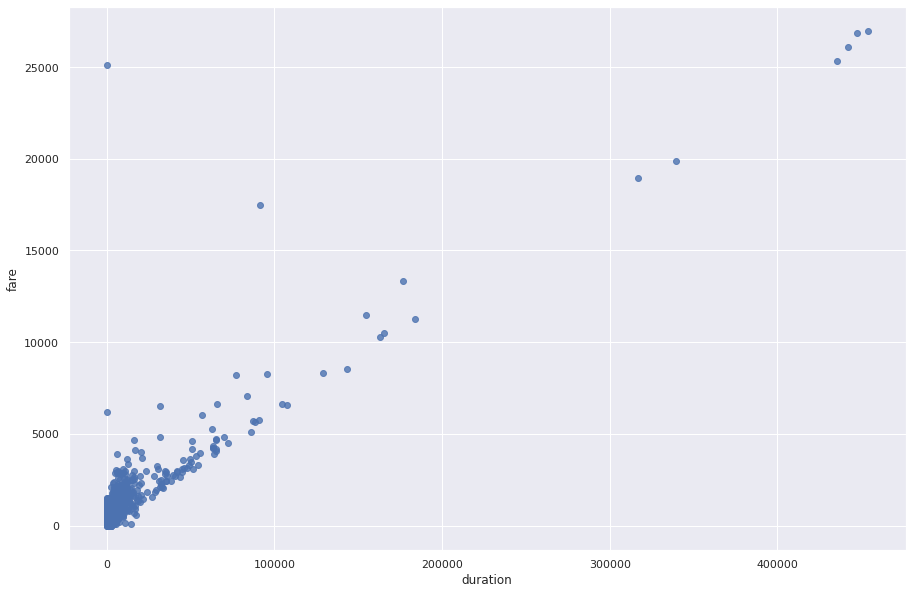

In [1259]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax = sns.regplot(x="duration",y="fare",fit_reg=False,ci=None,truncate=True,data=dataset)



In [0]:
#dataset['mul_duration'] = dataset.duration * dataset.duration

#fig, ax = plt.subplots()
#fig.set_size_inches(15,10)
#ax = sns.regplot(x="mul_duration",y="fare",fit_reg=False,ci=None,truncate=True,data=dataset)



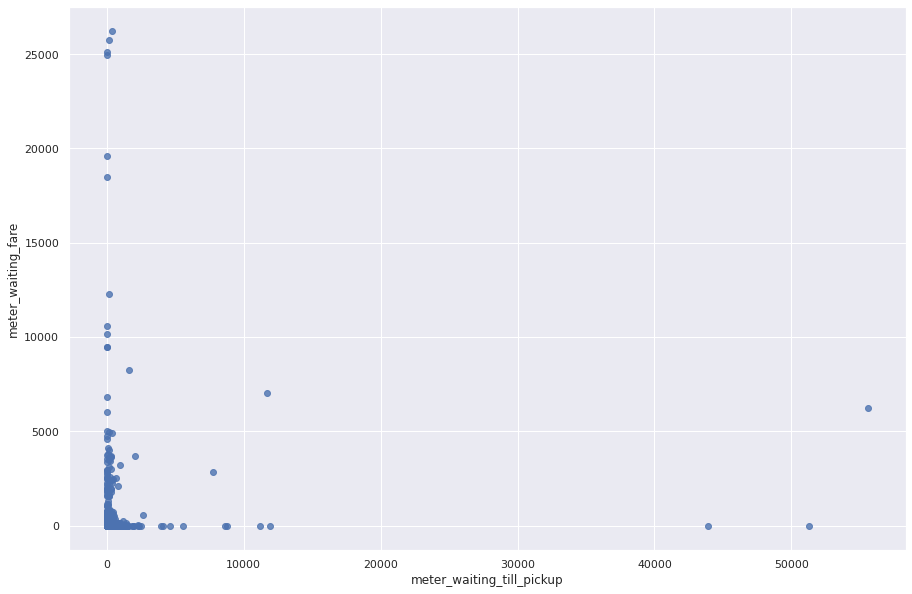

In [1261]:
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax = sns.regplot(x="meter_waiting_till_pickup",y="meter_waiting_fare",fit_reg=False,ci=None,truncate=True,data=dataset)


In [0]:
#dataset['mul_meter_waiting'] = dataset.meter_waiting * dataset.meter_waiting
#fig, ax = plt.subplots()
#fig.set_size_inches(15,10)
#ax = sns.regplot(x="meter_waiting_fare",y="mul_meter_waiting",fit_reg=False,ci=None,truncate=True,data=dataset)

In [0]:
#fig = plt.figure(figsize=(6, 6))
#plt.scatter(x="duration",y="actual_fare",
          # linewidths=1, alpha=.7,
         #  edgecolor='k',
         #  s = 200,
          # c='year',data=dataset)
#plt.show()

## Split dataset to train and test

In [0]:
test = dataset.loc[213284604:222860703]
test = test.drop(['label'], axis=1)



In [0]:
train = dataset.loc[189123628:213817296]
convert_dict = {'label': 'int64'}
train = train.astype(convert_dict) 


In [1266]:
dataset

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance_val,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster,drop_location_cluster,season,day_category
tripid,,,,,,,,,,,,,,,,,,,,,,,,,,
189123628,5,834.0,56.0,0.00000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1.0,5.072065,0,11,1,0,20,0,34,4,0,0,2,0
189125358,5,791.0,47.0,0.00000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1.0,3.151780,0,11,1,0,56,1,9,4,0,0,2,0
189125719,5,1087.0,80.0,0.00000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1.0,6.302418,0,11,1,1,8,1,26,4,0,0,2,0
189127273,5,598.0,271.0,15.66380,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1.0,0.862654,0,11,1,2,27,2,37,4,0,0,2,0
189128020,5,1713.6,373.8,10.89794,29.0,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1.0,8.148521,0,11,1,3,34,3,51,4,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,5,1723.0,429.0,24.83332,3.0,2020-03-16 21:28:00,2020-03-16 21:56:00,6.85103,79.9567,6.85588,79.9214,388.48,NaN,3.938380,1,3,16,21,28,21,56,0,0,0,0,0
222857785,5,1378.0,80.0,0.00000,125.0,2020-03-16 21:59:00,2020-03-16 22:22:00,6.91293,79.9656,6.92112,79.8980,379.85,NaN,7.525493,1,3,16,21,59,22,22,0,0,0,0,0
222858416,5,418.0,56.0,3.28440,93.0,2020-03-16 22:02:00,2020-03-16 22:09:00,6.85718,79.9081,6.83868,79.9083,112.79,NaN,2.046036,1,3,16,22,2,22,9,0,0,0,0,0


In [1267]:
dataset

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,distance_val,year,month,day,pickup_hour,pickup_min,drop_hour,drop_min,weekday,pick_location_cluster,drop_location_cluster,season,day_category
tripid,,,,,,,,,,,,,,,,,,,,,,,,,,
189123628,5,834.0,56.0,0.00000,64.0,2019-11-01 00:20:00,2019-11-01 00:34:00,6.86252,79.8993,6.90330,79.8783,270.32,1.0,5.072065,0,11,1,0,20,0,34,4,0,0,2,0
189125358,5,791.0,47.0,0.00000,134.0,2019-11-01 00:56:00,2019-11-01 01:09:00,6.88589,79.8984,6.91373,79.8923,197.85,1.0,3.151780,0,11,1,0,56,1,9,4,0,0,2,0
189125719,5,1087.0,80.0,0.00000,61.0,2019-11-01 01:08:00,2019-11-01 01:26:00,6.90839,79.8651,6.93669,79.9146,301.64,1.0,6.302418,0,11,1,1,8,1,26,4,0,0,2,0
189127273,5,598.0,271.0,15.66380,68.0,2019-11-01 02:27:00,2019-11-01 02:37:00,6.92570,79.8895,6.92748,79.8971,82.30,1.0,0.862654,0,11,1,2,27,2,37,4,0,0,2,0
189128020,5,1713.6,373.8,10.89794,29.0,2019-11-01 03:34:00,2019-11-01 03:51:00,6.87441,79.8615,6.84478,79.9290,358.39,1.0,8.148521,0,11,1,3,34,3,51,4,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,5,1723.0,429.0,24.83332,3.0,2020-03-16 21:28:00,2020-03-16 21:56:00,6.85103,79.9567,6.85588,79.9214,388.48,NaN,3.938380,1,3,16,21,28,21,56,0,0,0,0,0
222857785,5,1378.0,80.0,0.00000,125.0,2020-03-16 21:59:00,2020-03-16 22:22:00,6.91293,79.9656,6.92112,79.8980,379.85,NaN,7.525493,1,3,16,21,59,22,22,0,0,0,0,0
222858416,5,418.0,56.0,3.28440,93.0,2020-03-16 22:02:00,2020-03-16 22:09:00,6.85718,79.9081,6.83868,79.9083,112.79,NaN,2.046036,1,3,16,22,2,22,9,0,0,0,0,0


In [1268]:
dataset.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'pickup_time', 'drop_time', 'pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'label', 'distance_val',
       'year', 'month', 'day', 'pickup_hour', 'pickup_min', 'drop_hour',
       'drop_min', 'weekday', 'pick_location_cluster', 'drop_location_cluster',
       'season', 'day_category'],
      dtype='object')

## Setup data to train model

In [1269]:
train_features = train[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'fare', 'distance_val',
       'year', 'month', 'day', 'pickup_min',
       'pick_location_cluster', 'drop_location_cluster',
       'season', 'day_category']]
print(train_features.info())
train_features

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17172 entries, 189123628 to 213817296
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            17172 non-null  int8   
 1   duration                   17172 non-null  float64
 2   meter_waiting              17172 non-null  float64
 3   meter_waiting_fare         17172 non-null  float64
 4   meter_waiting_till_pickup  17172 non-null  float64
 5   fare                       17172 non-null  float64
 6   distance_val               17172 non-null  float64
 7   year                       17172 non-null  int8   
 8   month                      17172 non-null  int64  
 9   day                        17172 non-null  int64  
 10  pickup_min                 17172 non-null  int64  
 11  pick_location_cluster      17172 non-null  int32  
 12  drop_location_cluster      17172 non-null  int32  
 13  season                     17172 n

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,distance_val,year,month,day,pickup_min,pick_location_cluster,drop_location_cluster,season,day_category
tripid,,,,,,,,,,,,,,,
189123628,5,834.0,56.0,0.00000,64.0,270.32,5.072065,0,11,1,20,0,0,2,0
189125358,5,791.0,47.0,0.00000,134.0,197.85,3.151780,0,11,1,56,0,0,2,0
189125719,5,1087.0,80.0,0.00000,61.0,301.64,6.302418,0,11,1,8,0,0,2,0
189127273,5,598.0,271.0,15.66380,68.0,82.30,0.862654,0,11,1,27,0,0,2,0
189128020,5,1713.6,373.8,10.89794,29.0,358.39,8.148521,0,11,1,34,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,5,838.0,93.0,5.42190,451.0,198.26,2.107720,1,1,31,7,1,2,3,0
213812756,5,2151.0,428.0,0.00000,39.0,581.23,10.865770,1,1,31,7,0,0,3,0
213813930,5,263.0,9.0,0.00000,110.0,76.20,1.040065,1,1,31,21,0,0,3,0


In [1270]:
train_lable = train[['label']]
print(train_lable.info())
train_lable

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17172 entries, 189123628 to 213817296
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   17172 non-null  int64
dtypes: int64(1)
memory usage: 268.3 KB
None


,label
tripid,
189123628,1
189125358,1
189125719,1
189127273,1
189128020,1
...,...
213803193,1
213812756,1
213813930,1


In [1271]:
test_features = test[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'fare', 'distance_val',
       'year', 'month', 'day', 'pickup_min',
       'pick_location_cluster', 'drop_location_cluster',
       'season', 'day_category']]

print(test_features.info())
test_features


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8576 entries, 213284604 to 222860703
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            8576 non-null   int8   
 1   duration                   8576 non-null   float64
 2   meter_waiting              8576 non-null   float64
 3   meter_waiting_fare         8576 non-null   float64
 4   meter_waiting_till_pickup  8576 non-null   float64
 5   fare                       8576 non-null   float64
 6   distance_val               8576 non-null   float64
 7   year                       8576 non-null   int8   
 8   month                      8576 non-null   int64  
 9   day                        8576 non-null   int64  
 10  pickup_min                 8576 non-null   int64  
 11  pick_location_cluster      8576 non-null   int32  
 12  drop_location_cluster      8576 non-null   int32  
 13  season                     8576 non

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,distance_val,year,month,day,pickup_min,pick_location_cluster,drop_location_cluster,season,day_category
tripid,,,,,,,,,,,,,,,
213284604,5,924.0,42.0,2.44860,148.0,289.27,6.670189,1,2,1,38,0,0,3,1
213286352,5,4249.0,20.0,0.00000,91.0,1912.70,41.351053,1,2,1,2,0,0,3,1
213293973,5,1552.0,255.0,2.65880,23.0,394.00,5.920044,1,2,1,2,0,0,3,1
213294622,5,462.0,16.0,0.00000,198.0,154.32,3.283813,1,2,1,30,0,0,3,1
213298687,5,814.0,392.0,12.36920,69.0,147.47,2.588982,1,2,1,0,0,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222856243,5,1723.0,429.0,24.83332,3.0,388.48,3.938380,1,3,16,28,0,0,0,0
222857785,5,1378.0,80.0,0.00000,125.0,379.85,7.525493,1,3,16,59,0,0,0,0
222858416,5,418.0,56.0,3.28440,93.0,112.79,2.046036,1,3,16,2,0,0,0,0


## Feature Importance

In [1272]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# apply SelectKBest class to extract top features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(train_features, train_lable)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train_features.columns)

# concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
print(featureScores.nlargest(25, 'Score'))

                        Specs         Score
2               meter_waiting  1.857011e+07
1                    duration  7.718370e+06
3          meter_waiting_fare  1.126869e+06
5                        fare  6.192472e+05
4   meter_waiting_till_pickup  3.432444e+04
0             additional_fare  9.700958e+02
8                       month  7.550695e+01
12      drop_location_cluster  4.712037e+01
7                        year  2.094410e+01
9                         day  1.888808e+01
11      pick_location_cluster  1.119993e+01
13                     season  8.598369e+00
10                 pickup_min  4.348388e+00
14               day_category  3.224447e+00
6                distance_val  6.732476e-01


## CAT Boost

In [1273]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier, cv

convert_dict2 = {'additional_fare': 'int64'}
train_features = train_features.astype(convert_dict2) 
convert_dict2 = {'additional_fare': 'int64'}
test_features = test_features.astype(convert_dict2) 





Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## Grid SearchCV

## Not tuned

In [1274]:
rnd_state = 42

# make train val split to try out-of-the-box
X_train, X_val, y_train, y_val = train_test_split(train_features, train_lable, test_size=0.2, random_state=rnd_state)

categorical_features_indices = np.where(train_features.dtypes != np.float)[0]
clf = CatBoostClassifier(random_seed=rnd_state, custom_metric='Accuracy')
clf.fit(X_train, y_train, cat_features=categorical_features_indices)
clf.score(X_val, y_val)
#Learning rate set to 0.031537

Learning rate set to 0.031537
0:	learn: 0.6587936	total: 46.1ms	remaining: 46s
1:	learn: 0.6308637	total: 63.4ms	remaining: 31.6s
2:	learn: 0.6057231	total: 89ms	remaining: 29.6s
3:	learn: 0.5816131	total: 115ms	remaining: 28.7s
4:	learn: 0.5600097	total: 138ms	remaining: 27.5s
5:	learn: 0.5406469	total: 151ms	remaining: 25s
6:	learn: 0.5178361	total: 184ms	remaining: 26.1s
7:	learn: 0.4955182	total: 220ms	remaining: 27.3s
8:	learn: 0.4776029	total: 246ms	remaining: 27.1s
9:	learn: 0.4602353	total: 277ms	remaining: 27.4s
10:	learn: 0.4421992	total: 311ms	remaining: 27.9s
11:	learn: 0.4306716	total: 325ms	remaining: 26.8s
12:	learn: 0.4145353	total: 365ms	remaining: 27.7s
13:	learn: 0.3983203	total: 400ms	remaining: 28.2s
14:	learn: 0.3876998	total: 436ms	remaining: 28.6s
15:	learn: 0.3744048	total: 470ms	remaining: 28.9s
16:	learn: 0.3645050	total: 496ms	remaining: 28.7s
17:	learn: 0.3531607	total: 526ms	remaining: 28.7s
18:	learn: 0.3425754	total: 558ms	remaining: 28.8s
19:	learn: 0.3

0.9537117903930131

In [1275]:
# Submission 1: catboost submission with all training data and early stopping on Accuracy

clf_od = CatBoostClassifier(learning_rate=0.02, random_seed=rnd_state, od_type='Iter', od_wait=20, eval_metric='Accuracy')
clf_od.fit(train_features, train_lable, cat_features=categorical_features_indices)


prediction = clf_od.predict(test_features).astype('int')

0:	learn: 0.9182390	total: 38.1ms	remaining: 38.1s
1:	learn: 0.9188213	total: 70ms	remaining: 34.9s
2:	learn: 0.9142208	total: 104ms	remaining: 34.5s
3:	learn: 0.9165502	total: 142ms	remaining: 35.4s
4:	learn: 0.9157932	total: 171ms	remaining: 34s
5:	learn: 0.9162590	total: 201ms	remaining: 33.3s
6:	learn: 0.9175402	total: 237ms	remaining: 33.6s
7:	learn: 0.9152690	total: 260ms	remaining: 32.2s
8:	learn: 0.9132891	total: 276ms	remaining: 30.4s
9:	learn: 0.9117750	total: 299ms	remaining: 29.6s
10:	learn: 0.9099697	total: 332ms	remaining: 29.9s
11:	learn: 0.9118332	total: 370ms	remaining: 30.5s
12:	learn: 0.9095621	total: 381ms	remaining: 28.9s
13:	learn: 0.9108432	total: 419ms	remaining: 29.5s
14:	learn: 0.9114256	total: 470ms	remaining: 30.9s
15:	learn: 0.9105521	total: 510ms	remaining: 31.3s
16:	learn: 0.9104938	total: 547ms	remaining: 31.6s
17:	learn: 0.9095038	total: 573ms	remaining: 31.3s
18:	learn: 0.9089797	total: 602ms	remaining: 31.1s
19:	learn: 0.9072909	total: 613ms	remaining

In [1276]:

index=[]
for ind in test_features.index:
  index.append(ind)

test_features['tripid'] = index

submission = pd.DataFrame({
        "tripid": test_features["tripid"],
        "prediction": prediction
    })
submission = submission.drop(['tripid'],1)
test_features = test_features.drop(['tripid'],1)
print(submission['prediction'].value_counts())
submission

1    8248
0     328
Name: prediction, dtype: int64


,prediction
tripid,
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1
...,...
222856243,1
222857785,1
222858416,1


In [1277]:
DATA_PATH = '/content/drive/My Drive/Data Sets/ML data/output'
sub_path = DATA_PATH + 'sub27_cat_best_lr_02.csv'
submission.to_csv(sub_path, index=True)
print('Completed!')

Completed!
